In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, ConfusionMatrixDisplay,
                           roc_curve, auc, precision_recall_curve, average_precision_score)

# Set random seed for reproducibility
np.random.seed(42)

# 1. Data Loading and Preprocessing

In [19]:
# Load the data
file_path = 'winequality-red-4.csv'

# Read and clean column names
with open(file_path, 'r', encoding='utf-8') as f:
    header_line = f.readline().strip()
    
raw_columns = header_line.split(';')
clean_columns = [col.replace('""', '"').strip('"') for col in raw_columns]

# Load data with cleaned column names
data = pd.read_csv(
    file_path,
    sep=';',
    header=None,
    names=clean_columns,
    skiprows=1,
    engine='python',
    on_bad_lines='skip'
)

# Initial data inspection
print("Data Info:")
print(data.info())
print("\nChecking for missing values:")
print(data.isnull().sum())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None

Checking for missing values:
fixed acidity           0
volatile acidity        0
citric acid             0
re

# 2. Exploratory Data Analysis

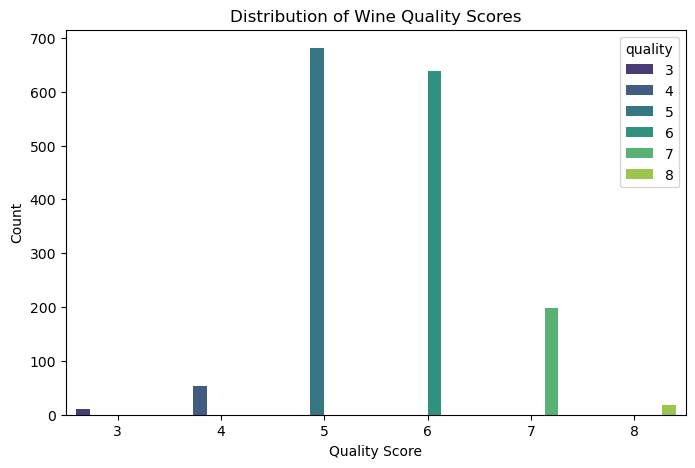

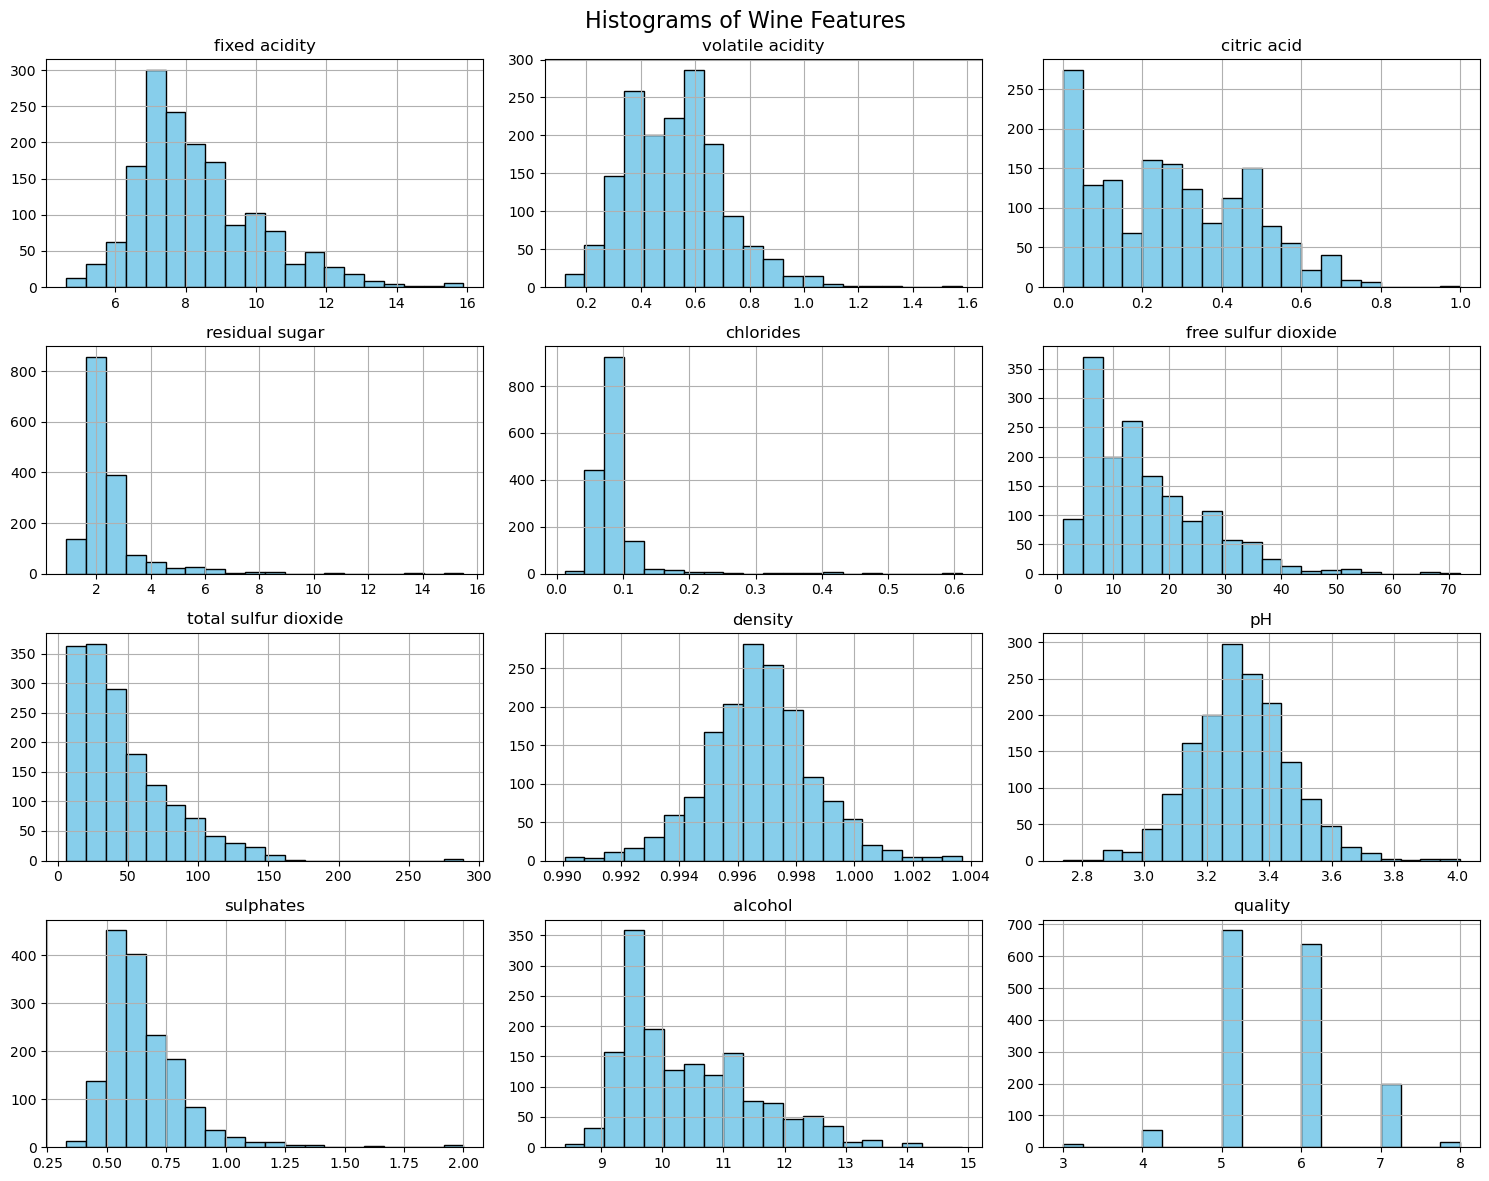

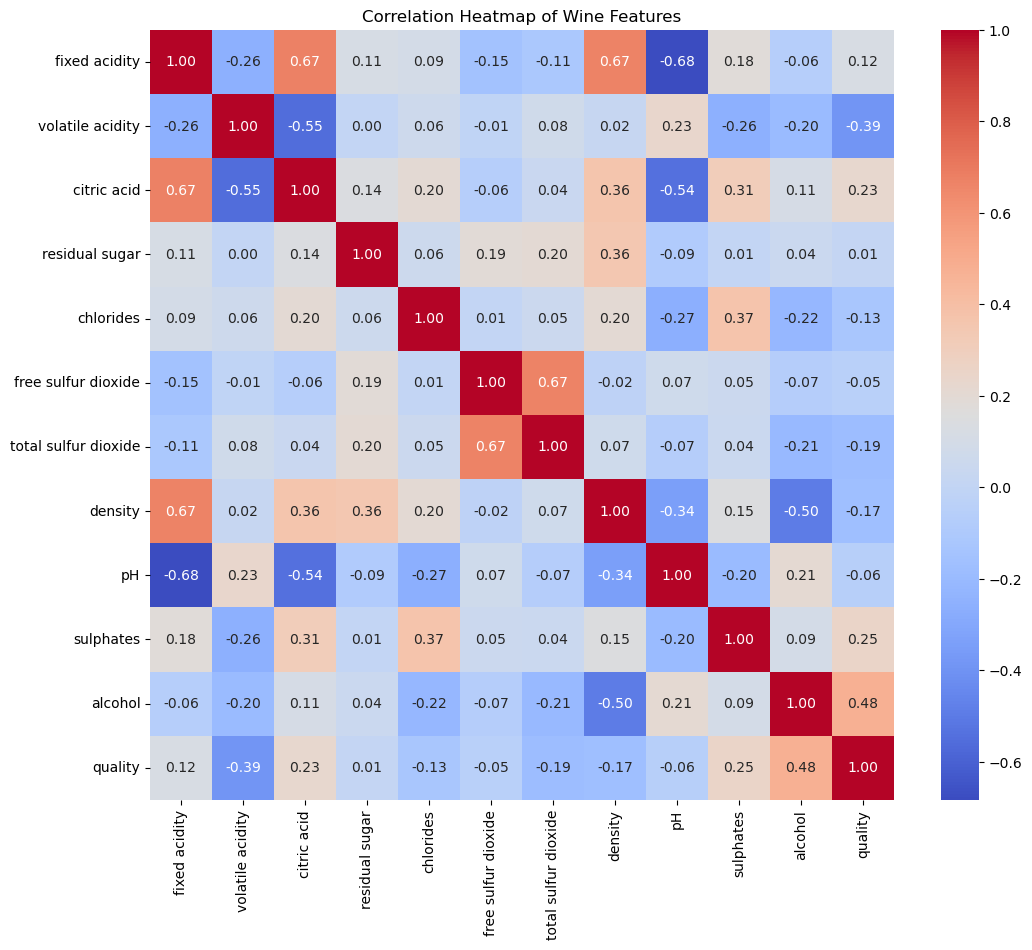

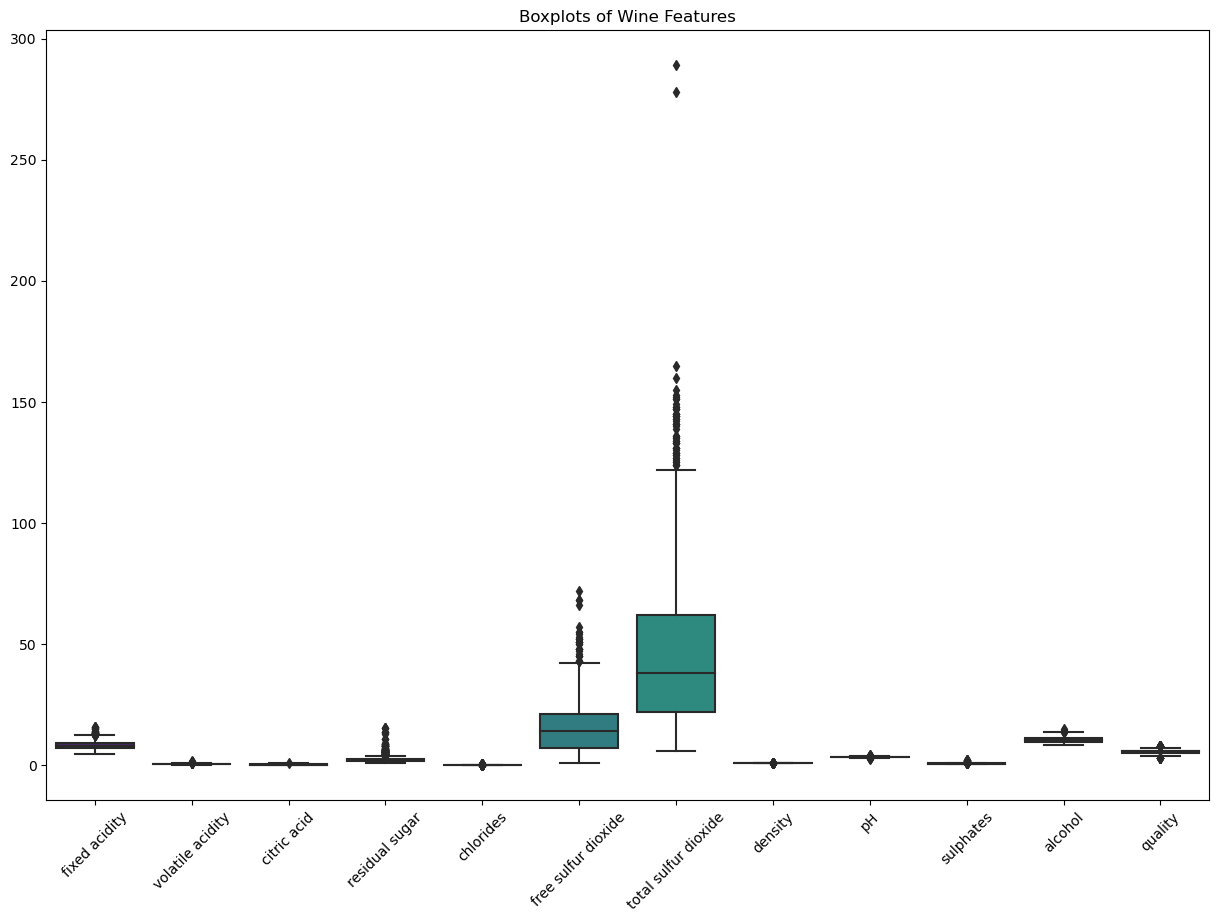

In [ ]:
# Distribution of wine quality scores
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='quality', hue='quality', legend=False, palette='viridis')
plt.title('Distribution of Wine Quality Scores')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.show()

# Feature distributions
data.hist(bins=20, figsize=(15, 12), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Wine Features', fontsize=16)
plt.tight_layout()
plt.show()

# Correlation analysis
plt.figure(figsize=(12, 10))
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Wine Features')
plt.show()

# Feature distributions by box plots
plt.figure(figsize=(15, 10))
sns.boxplot(data=data, palette='viridis')
plt.title('Boxplots of Wine Features')
plt.xticks(rotation=45)
plt.show()

# 3. Feature Engineering and Selection

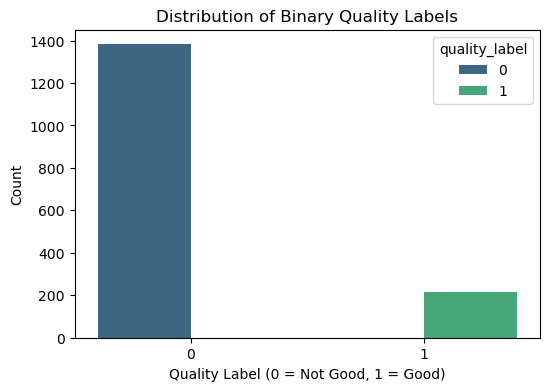

In [ ]:
# Convert quality to binary classification (good wine vs not good wine)
data['quality_label'] = (data['quality'] >= 7).astype(int)  # Define 'good' wine as quality >= 7

# Visualize class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='quality_label', hue='quality_label', legend=False, palette='viridis')
plt.title('Distribution of Binary Quality Labels')
plt.xlabel('Quality Label (0 = Not Good, 1 = Good)')
plt.ylabel('Count')
plt.show()

# Prepare features and target
X = data.drop(['quality', 'quality_label'], axis=1)
y = data['quality_label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Model Training and Hyperparameter Tuning

In [37]:
# Grid search for hyperparameter tuning
# SVM
svm_params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
svm_grid = GridSearchCV(SVC(), svm_params, cv=5)
svm_grid.fit(X_train, y_train)
svm_model = svm_grid.best_estimator_

# ANN
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50,25)],
    'alpha': [0.0001, 0.001, 0.01]
}
mlp_grid = GridSearchCV(
    MLPClassifier(max_iter=2000, random_state=42),
    mlp_params,
    cv=5
)
mlp_grid.fit(X_train, y_train)
mlp_model = mlp_grid.best_estimator_

# Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=5
)
rf_grid.fit(X_train, y_train)
rf_model = rf_grid.best_estimator_

print("Best Parameters for SVM:", svm_grid.best_params_)
print("Best Parameters for ANN:", mlp_grid.best_params_)
print("Best Parameters for Random Forest:", rf_grid.best_params_)

Best Parameters for SVM: {'C': 1, 'gamma': 'scale'}
Best Parameters for ANN: {'alpha': 0.001, 'hidden_layer_sizes': (100,)}
Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 200}


# 5. Model Evaluation and Comparison

In [23]:
def evaluate_model(model, X_test, y_test):
    """Evaluate a model and return performance metrics."""
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    return acc, prec, rec, f1

# Evaluate all models
svm_metrics = evaluate_model(svm_model, X_test, y_test)
mlp_metrics = evaluate_model(mlp_model, X_test, y_test)
rf_metrics = evaluate_model(rf_model, X_test, y_test)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['SVM', 'ANN', 'Random Forest'],
    'Accuracy': [svm_metrics[0], mlp_metrics[0], rf_metrics[0]],
    'Precision': [svm_metrics[1], mlp_metrics[1], rf_metrics[1]],
    'Recall': [svm_metrics[2], mlp_metrics[2], rf_metrics[2]],
    'F1-Score': [svm_metrics[3], mlp_metrics[3], rf_metrics[3]]
})

print("Model Performance Comparison:")
print(comparison_df)

Model Performance Comparison:
           Model  Accuracy  Precision    Recall  F1-Score
0            SVM    0.9000   0.761905  0.372093  0.500000
1            ANN    0.9250   0.731707  0.697674  0.714286
2  Random Forest    0.9375   0.896552  0.604651  0.722222


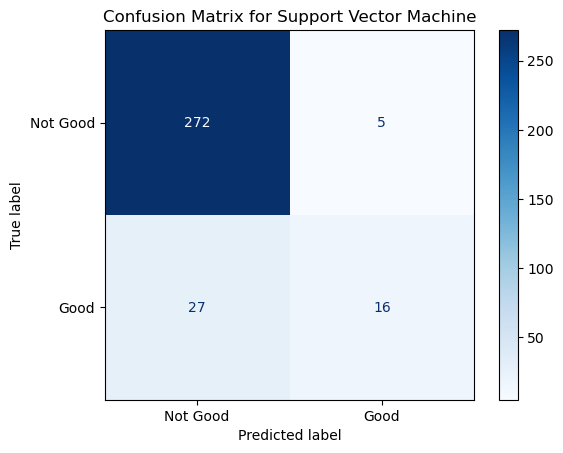

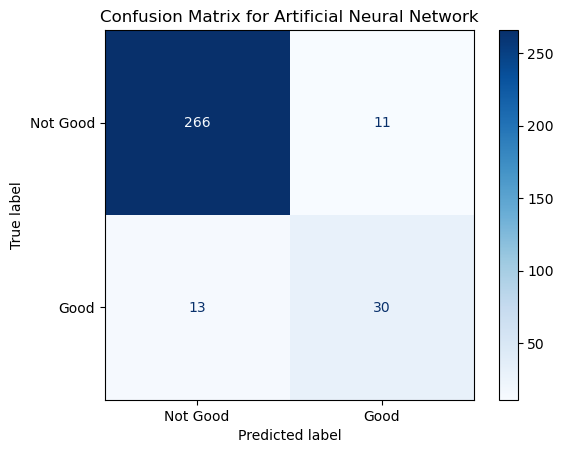

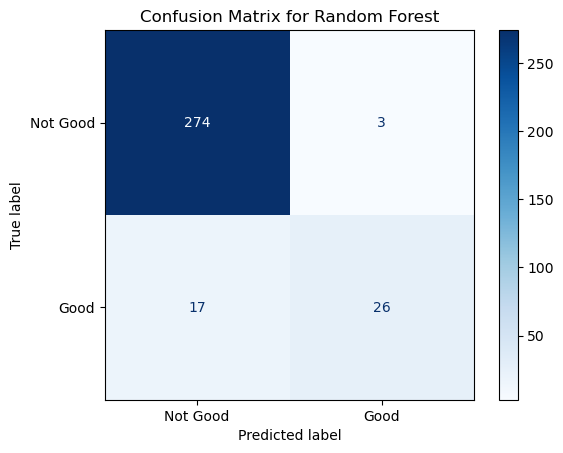

In [24]:
def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Good', 'Good'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(svm_model, X_test, y_test, 'Support Vector Machine')
plot_confusion_matrix(mlp_model, X_test, y_test, 'Artificial Neural Network')
plot_confusion_matrix(rf_model, X_test, y_test, 'Random Forest')

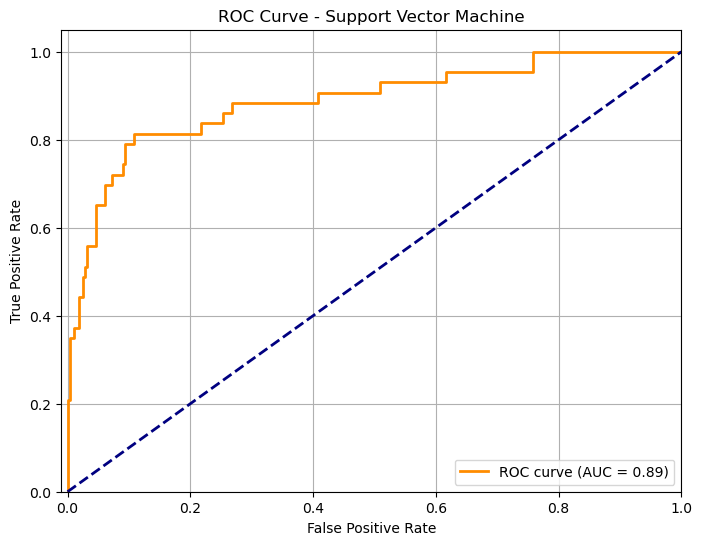

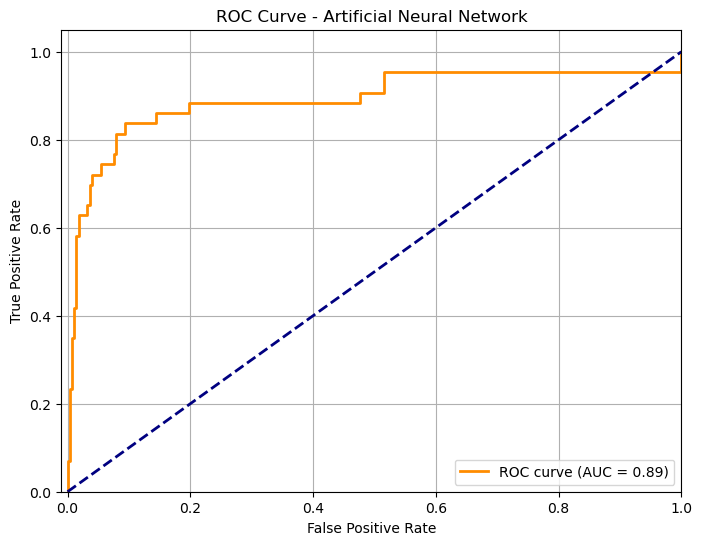

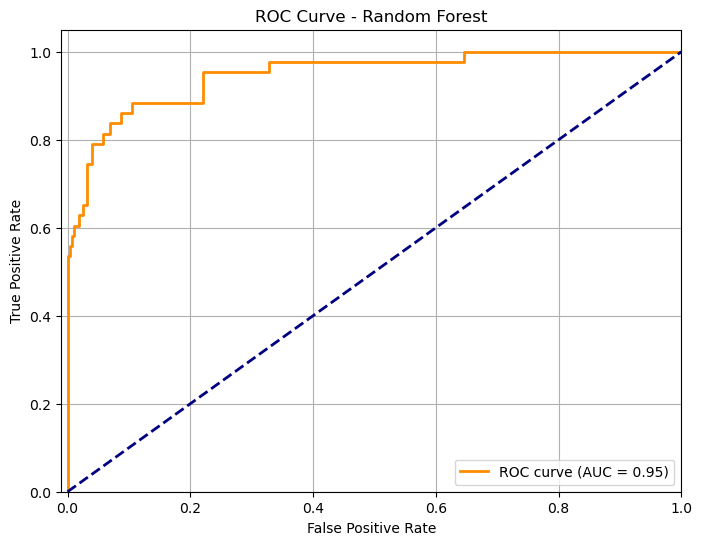

In [25]:
def plot_roc_curve(model, X_test, y_test, model_name):
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Plot ROC curves
plot_roc_curve(svm_model, X_test, y_test, 'Support Vector Machine')
plot_roc_curve(mlp_model, X_test, y_test, 'Artificial Neural Network')
plot_roc_curve(rf_model, X_test, y_test, 'Random Forest')

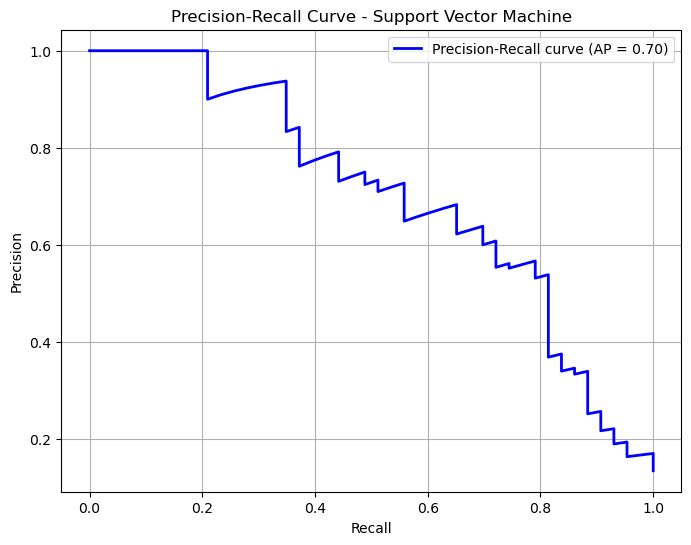

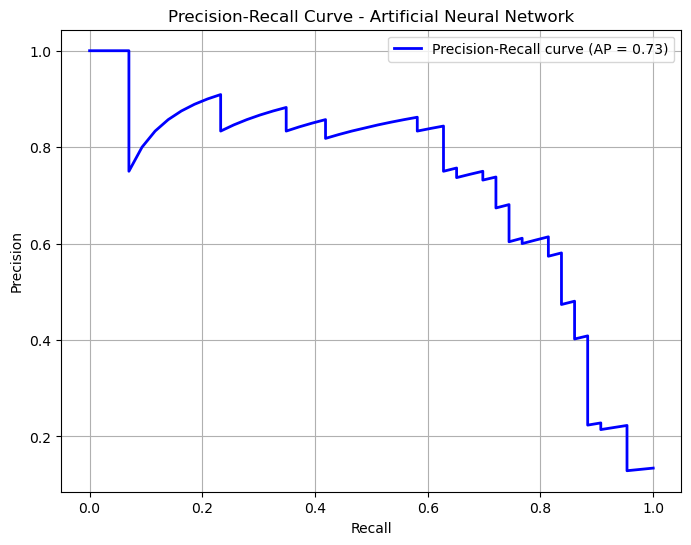

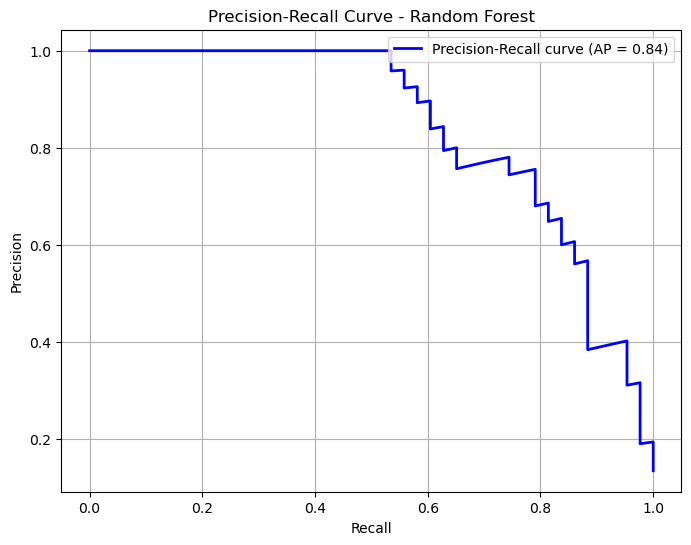

In [26]:
def plot_precision_recall(model, X_test, y_test, model_name):
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    avg_precision = average_precision_score(y_test, y_prob)
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color='blue', lw=2, 
             label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision') 
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

# Plot Precision-Recall curves
plot_precision_recall(svm_model, X_test, y_test, 'Support Vector Machine')
plot_precision_recall(mlp_model, X_test, y_test, 'Artificial Neural Network')
plot_precision_recall(rf_model, X_test, y_test, 'Random Forest')

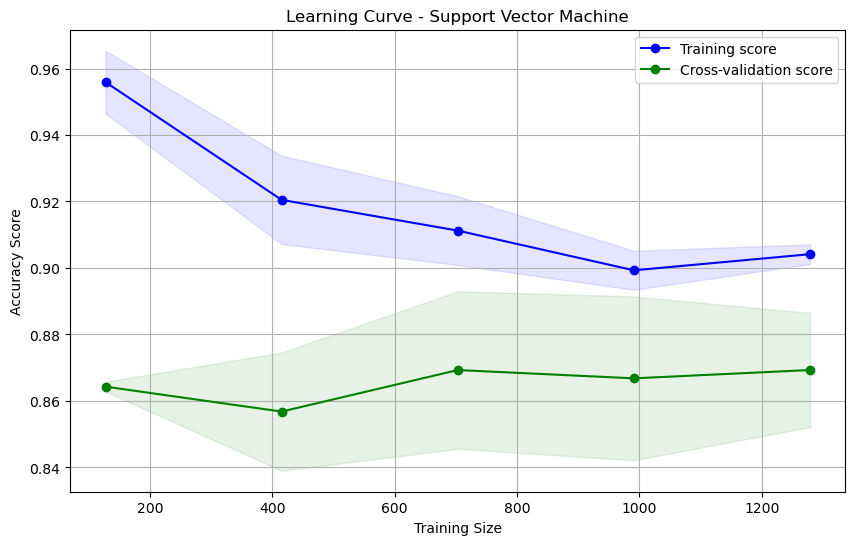

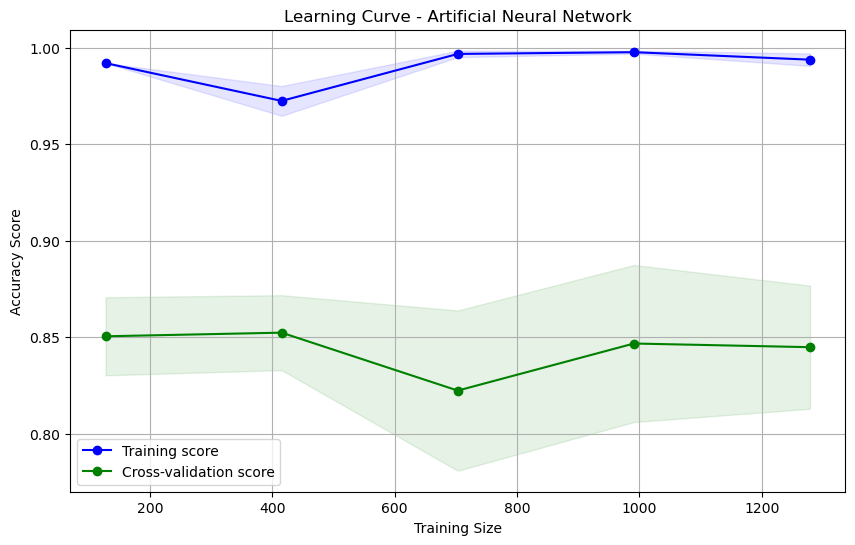

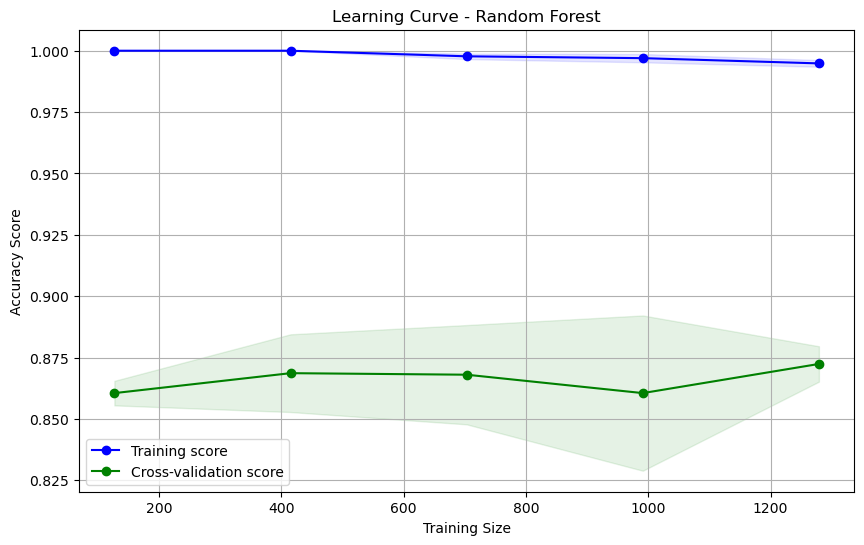

In [27]:
def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(.1, 1.0, 5),
        scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10,6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                    alpha=0.1, color='blue')
    plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, 
                    alpha=0.1, color='green')
    
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy Score')
    plt.title(f'Learning Curve - {model_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Plot learning curves
plot_learning_curve(svm_model, X_scaled, y, 'Support Vector Machine')
plot_learning_curve(mlp_model, X_scaled, y, 'Artificial Neural Network')
plot_learning_curve(rf_model, X_scaled, y, 'Random Forest')

# 6. Error Analysis and Model Interpretability

In [28]:
def analyze_errors(model, X_test, y_test, feature_names):
    y_pred = model.predict(X_test)
    misclassified = X_test[y_pred != y_test]
    true_labels = y_test[y_pred != y_test]
    pred_labels = y_pred[y_pred != y_test]
    
    print("Misclassification Analysis:")
    print(f"Total misclassified samples: {len(misclassified)}")
    
    # Analyze feature distributions of misclassified examples
    misclassified_df = pd.DataFrame(misclassified, columns=feature_names)
    misclassified_df['True_Label'] = true_labels
    misclassified_df['Predicted_Label'] = pred_labels
    
    return misclassified_df.describe()

# Analyze errors for each model
print("\nSVM Error Analysis:")
svm_errors = analyze_errors(svm_model, X_test, y_test, X.columns)
print(svm_errors)

print("\nANN Error Analysis:")
mlp_errors = analyze_errors(mlp_model, X_test, y_test, X.columns)
print(mlp_errors)

print("\nRandom Forest Error Analysis:")
rf_errors = analyze_errors(rf_model, X_test, y_test, X.columns)
print(rf_errors)


SVM Error Analysis:
Misclassification Analysis:
Total misclassified samples: 32
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count      32.000000         32.000000    32.000000       32.000000   
mean        0.626088         -0.716685     0.662546        0.154272   
std         1.420288          0.906845     1.033614        1.182790   
min        -1.562514         -1.775497    -1.391472       -0.807957   
25%        -0.557086         -1.300646     0.238905       -0.329060   
50%         0.448342         -0.881661     0.919299       -0.240375   
75%         1.209595         -0.253182     1.291589       -0.080742   
max         3.838072          1.743983     2.151710        4.087440   

       chlorides  free sulfur dioxide  total sulfur dioxide    density  \
count  32.000000            32.000000             32.000000  32.000000   
mean   -0.262968            -0.131485             -0.118756  -0.169666   
std     0.362154             1.066767              1.9685

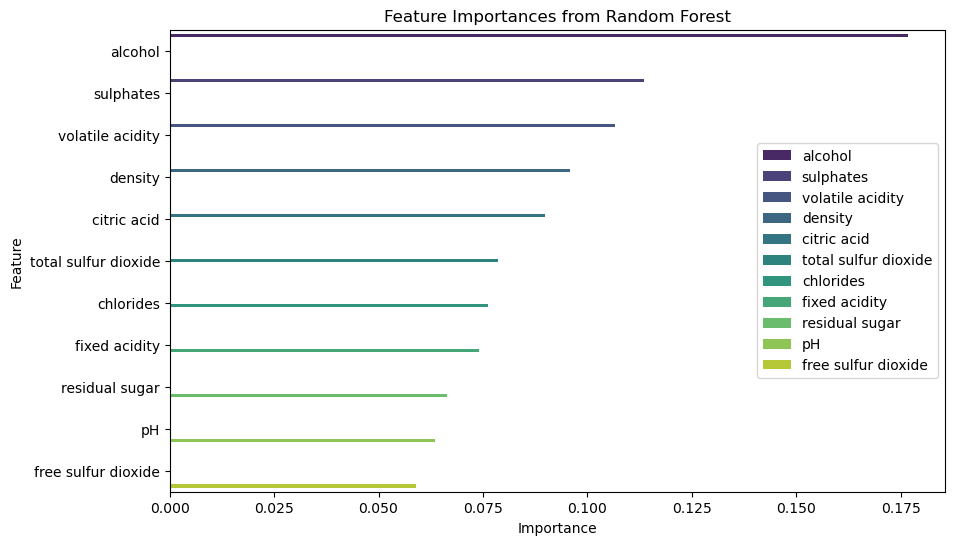

In [ ]:
# Extract and plot feature importances from Random Forest
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=feature_names[indices], hue=feature_names[indices], legend=False, palette='viridis')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()